In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import glob
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from wordcloud import WordCloud
%matplotlib inline

In [2]:
allFiles = glob.glob("*.txt")
frame = pd.DataFrame()
list_ = []
tid = []
date = []
content = []
filename = []
for file_ in allFiles:
    with open(file_, encoding = "utf-8", errors = "ignore") as f:
        for line in f:
            if line.strip():
                g = re.match(r'(\d+)(\|)(((?:Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday|Tues|Thur|Thurs|Sun|Mon|Tue|Wed|Thu|Fri|Sat))(\s+)((?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Sept|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?))(\s+)((?:(?:[0-2]?\d{1})|(?:[3][01]{1})))(?![\d])(\s+)((?:(?:[0-1][0-9])|(?:[2][0-3])|(?:[0-9])):(?:[0-5][0-9])(?::[0-5][0-9])?(?:\s?(?:am|AM|pm|PM))?)(\s+)(\+)(0000)(\s+)((?:(?:[1]{1}\d{1}\d{1}\d{1})|(?:[2]{1}\d{3})))(?![\d]))(\|)(.*)', line).groups()
                filename.append(file_[:-4])
                tid.append(g[0])
                date.append(g[2])
                content.append(g[16])
        concatenated_df = pd.DataFrame({'Account': filename, 'tid': tid, 'date': date, 'content': content})

In [3]:
concatenated_df.shape

(63326, 4)

In [4]:
def data_clean(df):
    stop = stopwords.words("english") + ['rt','says','audio','video','via','new','may','us','get', 'amp']
    df['Detail'] = df['content'].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in stop]))
    df['Detail'] = df['Detail'].apply(lambda x: re.sub("@[A-Za-z0-9]+|#[A-Za-z0-9]+|[0-9]+|http\S+|(.)\1+|\b[a-zA-Z]\b+|(?:^| )\w(?:$| )", '', x.lower()))
    df['Detail'] = df['Detail'].apply(lambda x: re.sub("[!@_#’$:)/'-.;,?&]", '', x.lower()))
    df['Detail'] = df['Detail'].apply(lambda x: re.sub('  ', ' ', x))
    df['Detail_length'] = [len(t) for t in df.Detail]
    df=df[df['Detail_length']!=0]
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.boxplot(df.Detail_length)
    plt.show()

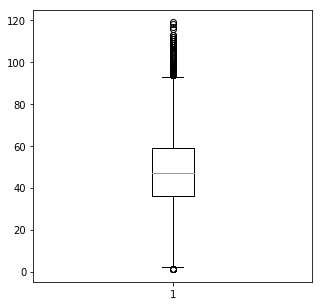

In [5]:
data_clean(concatenated_df)

In [6]:
def stemm(text):
    wordnet_porterstemmer = PorterStemmer()
    return ' '.join([wordnet_porterstemmer.stem(w) for w in nltk.word_tokenize(text.lower())])

concatenated_df['Detail'] = concatenated_df.Detail.apply(stemm)
concatenated_df.describe()

,Detail_length
count,63326.000000
mean,48.935398
std,17.176790
min,0.000000
25%,36.000000
50%,47.000000
75%,59.000000
max,119.000000


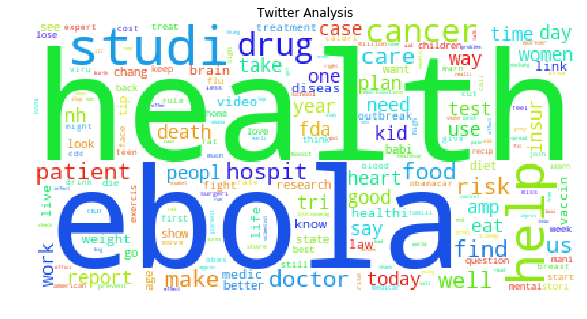

In [7]:
def wordcloud(df,col):
    wordcloud = WordCloud(background_color="white",random_state = 4).generate(" ".join([i for i in df[col]]))
    plt.figure( figsize=(10,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Twitter Analysis")
wordcloud(concatenated_df,'Detail') 

KaiserHealthNews
['health', 'report', 'insur', 'today', 'law', 'care', 'plan', 'hospit', 'state', 'medicar']
NBChealth
['studi', 'ebola', 'fda', 'health', 'cancer', 'kid', 'flu', 'work', 'help', 'food']
bbchealth
['video', 'ebola', 'nh', 'cancer', 'health', 'care', 'hospit', 'audio', 'patient', 'death']
cbchealth
['ebola', 'health', 'canada', 'doctor', 'cancer', 'outbreak', 'patient', 'studi', 'hospit', 'canadian']
cnnhealth
['today', 'tip', 'help', 'amp', 'kid', 'health', 'know', 'make', 'brain', 'stori']
everydayhealth
['food', 'eat', 'health', 'way', 'weight', 'healthi', 'help', 'today', 'amp', 'diet']
foxnewshealth
['studi', 'help', 'risk', 'drug', 'patient', 'cancer', 'brain', 'diseas', 'heart', 'doctor']
gdnhealthcare
['nh', 'health', 'patient', 'miss', 'care', 'need', 'today', 'work', 'healthcar', 'nurs']
goodhealth
['tri', 'make', 'food', 'way', 'healthi', 'day', 'help', 'amp', 'eat', 'weight']
latimeshealth
['studi', 'health', 'help', 'say', 'research', 'cancer', 'risk', 'drug

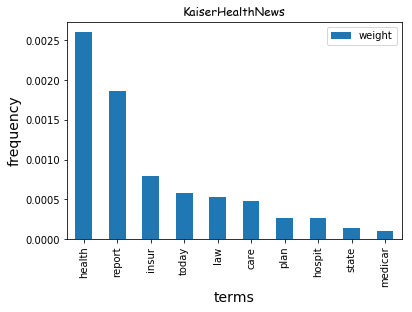

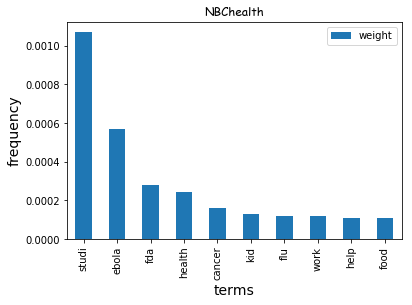

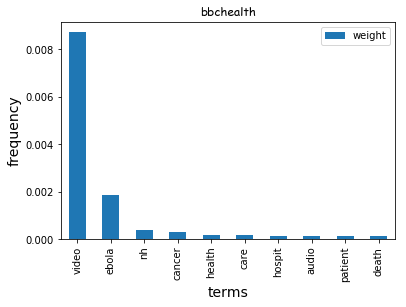

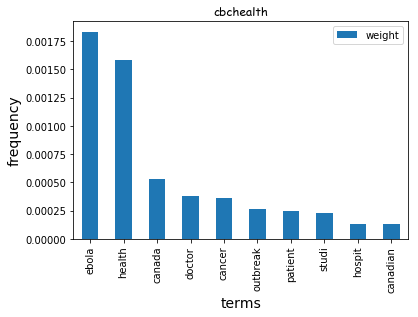

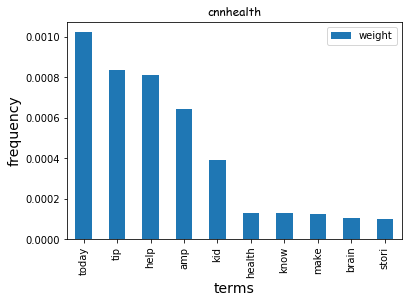

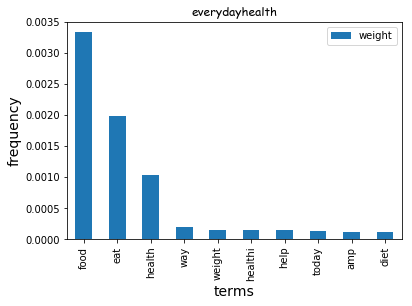

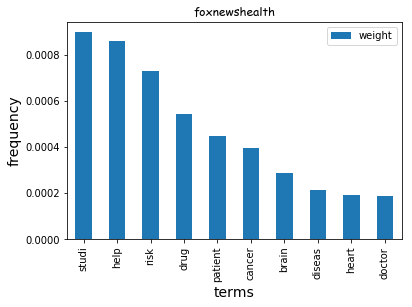

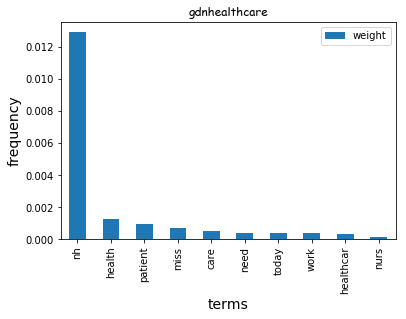

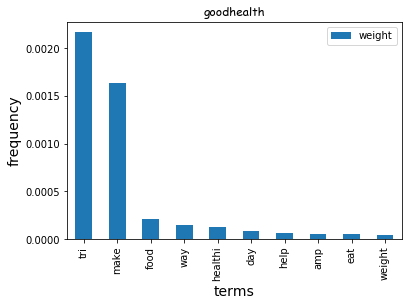

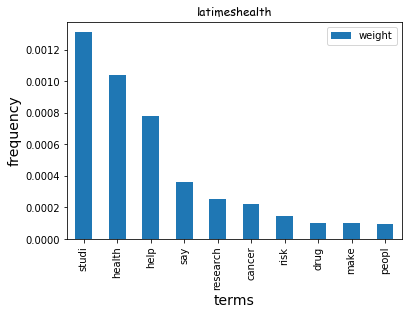

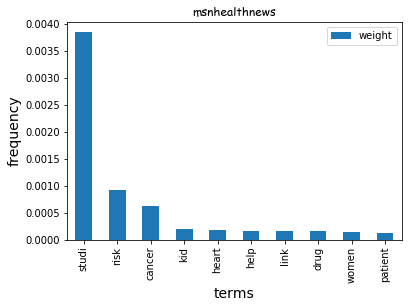

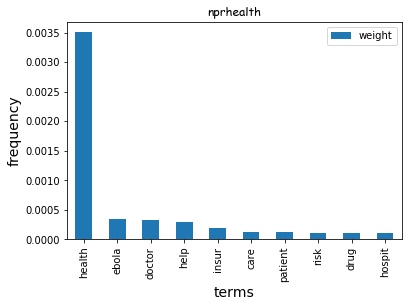

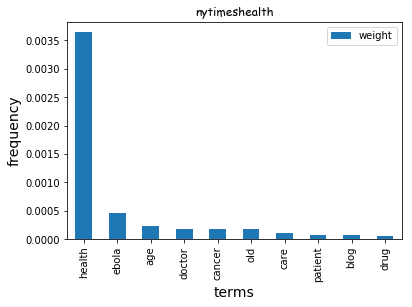

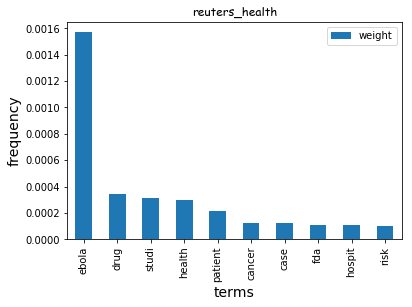

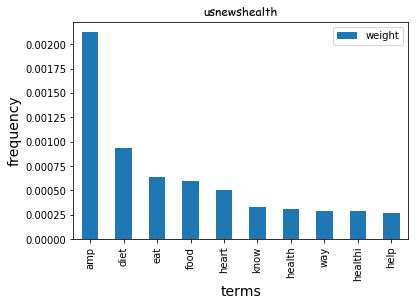

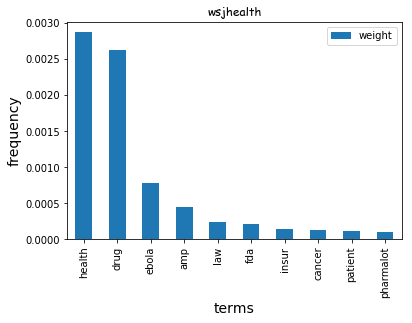

In [8]:
grouped = concatenated_df.groupby('Account')
for table, group in grouped:
    print(table)
    tfv = TfidfVectorizer(analyzer='word', stop_words = 'english')
    X = tfv.fit_transform(group.Detail)
    indices = np.argsort(tfv.idf_)[::1]
    features = tfv.get_feature_names()
    top_n = 10
    top_features = [features[i] for i in indices[:top_n]]
    print(top_features)
    weights = np.asarray(X.mean(axis=0)).ravel().tolist()[:top_n]
    weights_df = pd.DataFrame({'term': top_features, 'weight': weights})
    weights_df[['term','weight']].sort_values(by='weight', ascending=False).plot(kind='bar')
    plt.xticks(range(10),weights_df['term'])
    csfont = {'fontname':'Comic Sans MS'}
    plt.title(table, **csfont)
    plt.xlabel('terms', fontsize=14)
    plt.ylabel('frequency', fontsize=14)

In [9]:
concatenated_df['tokenized_text'] = concatenated_df['Detail'].apply(word_tokenize)
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(max_features = 15000, tokenizer=identity_tokenizer, analyzer='word', token_pattern=None, lowercase=False)
X = tfidf.fit_transform(list(concatenated_df.tokenized_text))

trun = TruncatedSVD(n_components = 2)
trun.fit(X)
transformed = trun.fit_transform(X)
word = tfidf.get_feature_names()

kmeans = KMeans(n_clusters=16)
kmeans.fit(transformed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [10]:
kmeans = KMeans(n_clusters=16)
pipeline = make_pipeline(trun, kmeans)
pipeline.fit(X)

Pipeline(memory=None,
     steps=[('truncatedsvd', TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [11]:
labels = pipeline.predict(X)

In [12]:
labels.ravel().shape

(63326,)

In [13]:
plt.rcParams["figure.dpi"] = 150

Text(0.5,1,'Clustering of health tweets - 16')

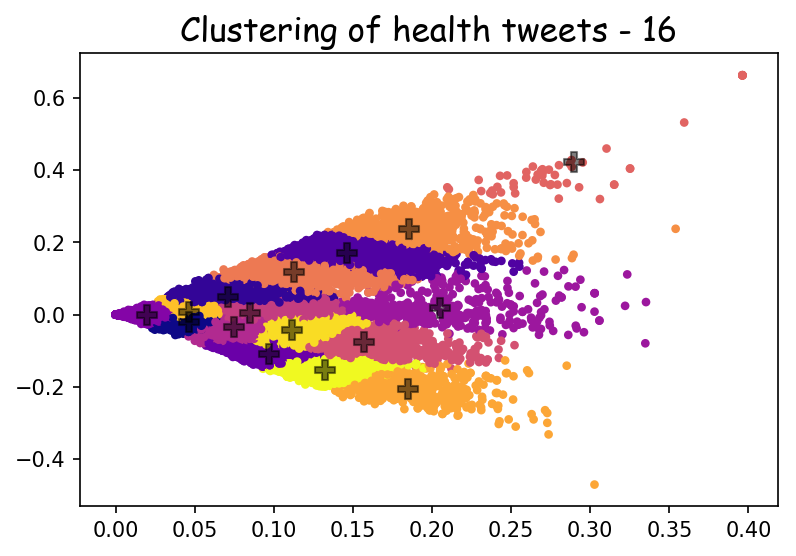

In [14]:
plt.scatter(transformed[:,0], transformed[:,1], c=labels, s=10, cmap = 'plasma')
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=100, alpha=0.5, marker = "P")
csfont = {'fontname':'Comic Sans MS', 'fontsize' : '16'}
plt.title("Clustering of health tweets - 16", **csfont)

In [15]:
kmeans_changed = KMeans(n_clusters=8)
pipeline_new = make_pipeline(trun, kmeans_changed)
pipeline_new.fit(X)

Pipeline(memory=None,
     steps=[('truncatedsvd', TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [16]:
labels_new = pipeline_new.predict(X)
labels_new.ravel().shape

(63326,)

In [17]:
plt.rcParams["figure.dpi"] = 150

Text(0.5,1,'Clustering of health tweets - 8')

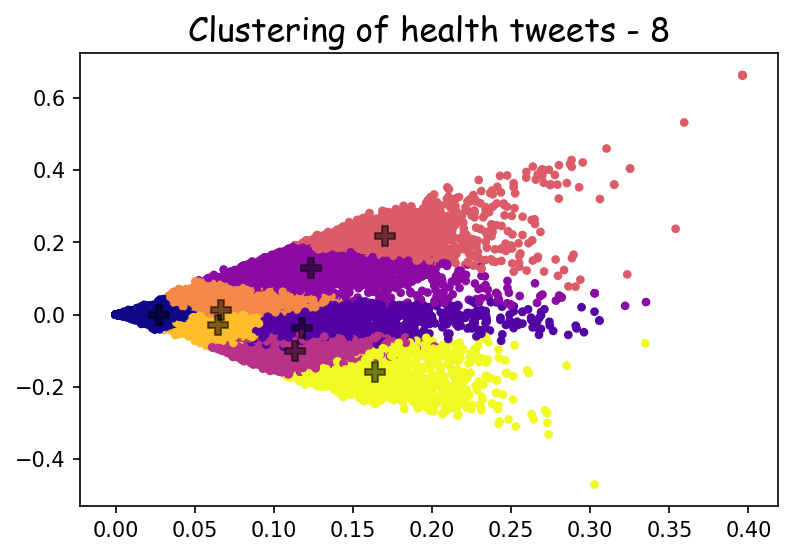

In [18]:
plt.scatter(transformed[:,0], transformed[:,1], c=labels_new, s=10, cmap = 'plasma')
centers = kmeans_changed.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=100, alpha=0.5, marker = "P")
csfont = {'fontname':'Comic Sans MS', 'fontsize' : '16'}
plt.title("Clustering of health tweets - 8", **csfont)